#### Setup Modules

In [1]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from matplotlib import rcParams
%matplotlib inline
rcParams.update({'font.size': 15, 'text.usetex': True})

In [3]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

In [4]:
# make qutip available in the rest of the notebook
from qutip import *

# Introduction

For a given set of bounded operators $\left\{\hat{A}_{j}:1\le j \le p\right\}$ which not necessarily commute with each other, the following relation

$$
e^{\hat{A}_1+\hat{A}_2 + \cdots \hat{A}_p} = \lim_{m \rightarrow \infty} \left(e^{\hat{A}_1/m} e^{\hat{A}_2/m} \cdots e^{\hat{A}_p/m}\right)^m
$$

is satisfied with the correction of $m^{-1}$. This equation, also known as the <i>generalized Trotter's formula</i> [<a href="http://link.springer.com/10.1007/BF01609348">1</a>, <a href="http://www.ams.org/jourcgi/jour-getitem?pii=S0002-9939-1959-0108732-6">2</a>], has been used as a key method of employing Monte Carlo simulation for quantum systems. We apply this formula to the time-evolution of a quantum system under total Hamiltonian for different values of positive integers $m$.

That is, we seek to find the way of treating the time-evolution of a system under total Hamiltonian $\hat{H} = \hat{H}_1 + \hat{H}_2 + \cdots + \hat{H}_p$ as applying short pulsed sequences of decomposed Hamiltonians $\hat{H}_{j}$ in a specific order. To do so, we define the time-evolution operator $\hat{U}$ and its approximant $\hat{\mathscr{U}}_m$ for an integer $m$ as
$$
\hat{U}(T) = e^{-i(\hat{H}_1 + \hat{H}_2 + \cdots + \hat{H}_p)T/\hbar},
$$ $$
\hat{\mathscr{U}}_m(T) = (e^{-i \hat{H}_1 T/m\hbar} e^{-i \hat{H}_2 T/m\hbar} \cdots e^{-i \hat{H}_p T/m\hbar})^m,
$$
where $T$ is the total evolution time. It is clear from the generalized Trotter's formula that $\hat{U}(T) = \lim_{m\rightarrow\infty} \hat{\mathscr{U}}_m (T)$. From now on, we call $m$ as a <i>fragmentation number</i>.

To quantify the error of this approximation, it is natural to investigate the overlap between two final states $\hat{U}(T) |i \rangle$ and $\hat{\mathscr{U}}_m (T)|i\rangle$, which are the states obtained by time-evolution and the corresponding approximated time-evolution. If the approximation holds, the overlap $\left|\langle i | \hat{\mathscr{U}}_m^\dagger U | i \rangle\right|$between the two aforementioned states, also known as the <i>fidelity</i> [3], would be close to 1.

# Rabi Model

As the simplest example, we consider the <i>Rabi model</i>, which describes an interaction of a two-level atom and a quantized mode of an optical cavity. The Hamiltonian is of the form:
$$
\hat{H} = \frac{1}{2} \hbar \Omega \hat{\sigma}_z + \hbar \omega \hat{a}^\dagger \hat{a} + \hbar g (\hat{\sigma}_+ + \hat{\sigma}_-) (\hat{a}^\dagger + \hat{a})
$$
Here, $\hat{\sigma}_z = \left| e \right>\left< e \right|-\left| g \right>\left< g \right|$ where $\left|e\right>$ and $\left|g\right>$ are the excited and the ground states of the two-level atom, respectively. This model is different from the <i>Jaynes-Cummings model</i> in which we neglect the counter-rotating terms $\hat{\sigma}_+ \hat{a}^\dagger$ and $\hat{\sigma}_- \hat{a}$.

## Decomposition into two parts

We first decompose the total Hamiltonian into two parts: 

$$
\hat{H}_1 = \frac{1}{2}\hbar \Omega \hat{\sigma}_z + \hbar g (\hat{\sigma}_+ \hat{a}^\dagger + \hat{\sigma}_- \hat{a}),\quad \hat{H}_2 = \hbar \omega \hat{a}^\dagger \hat{a} + \hbar g (\hat{\sigma}_+ \hat{a} + \hat{\sigma}_- \hat{a}^\dagger).
$$

It is clear that the two Hamiltonians $H_1$ and $H_2$ does not commute, so that we CANNOT claim that $\hat{U} =  \hat{\mathscr{U}}_m$.

We consider the resonant case where $\Omega =\omega = 20 g$. Suppose that the atom is initially in the excited state, while there is no cavity photon existent in the beginning. $|i\rangle \equiv |0, e\rangle$

In [72]:
N = 15         # number of cavity fock states

# intial state
psi0 = tensor(basis(N,0), basis(2,0))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sp = tensor(qeye(N), sigmap())
sm = tensor(qeye(N), sigmam())
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

In [6]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into two parts:
H_list = [wc * a.dag() * a + g * (a.dag() * sm.dag() + a * sm),
          0.5 * wa * sz + g * (a * sm.dag() + a.dag() * sm)]
H = sum(H_list)

In [7]:
def U(H, T):
    # normal unitary time-evolution
    return (-1j * H * T).expm()

def U_a(H_list, T, m):
    # approximated time-evolution (non-unitary)
    mult = 1
    for idx in range(len(H_list)):
        mult = mult * (-1j * H_list[idx] * T / m).expm()
    return mult ** m

In [8]:
M = 50   # maximum chopping number
m_list = range(1, M+1)

In [9]:
TT = 12     # maximum value of the total evolution time
dT = 2     # time step

T_list = np.arange(1e-4, TT, dT)

In [10]:
overlap = np.zeros((len(m_list), len(T_list)))

for i1, m in enumerate(m_list):
    for i2, T in enumerate(T_list):
        overlap[i1, i2] = fidelity(U_a(H_list, T, m) * psi0,
                                   U(H, T) * psi0)

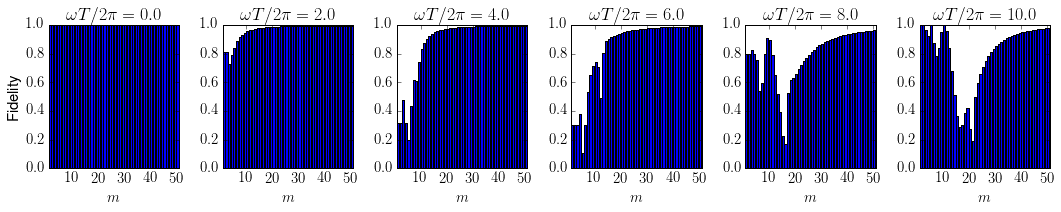

In [11]:
fig, ax = plt.subplots(1, len(T_list), figsize = (2.5 * len(T_list), 3.2))

for idx, T in enumerate(T_list):
    ax[idx].bar(m_list, overlap[:, idx])
    ax[idx].set_xlim([1, M + 1])
    ax[idx].set_ylim([0, 1])
    ax[idx].set_xlabel('$m$')
    ax[idx].set_title(r'$\omega T/2\pi = %.1f$' % T);
ax[0].set_ylabel('Fidelity')
fig.tight_layout();

In [12]:
TT = 25       # maximum value of the total evolution time
dT = 1e-2     # time step

T_list = np.arange(1e-4, TT, dT)

In [13]:
X, Y = np.meshgrid(m_list, T_list)
Z = np.zeros((len(T_list), len(m_list)))

for i1, m in enumerate(m_list):
    for i2, T in enumerate(T_list):
        rho_af = U_a(H_list, T, m) * psi0
        rho_0f = U(H, T) * psi0
        Z[i2, i1] = fidelity(rho_af, rho_0f)

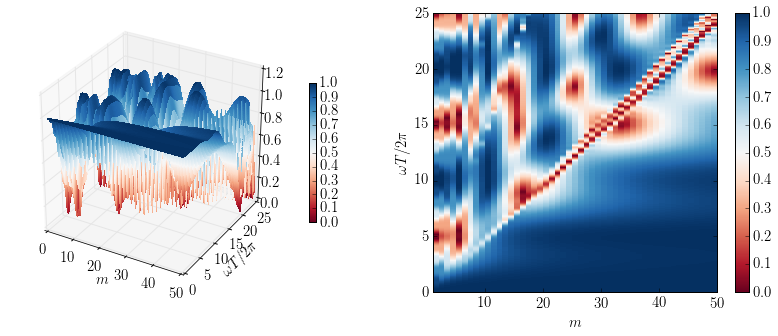

In [18]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
axes = []
axes.append(fig.add_subplot(1, 2, 1, projection='3d'))
p = axes[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu,
                         linewidth=0, antialiased=False, vmin=0, vmax=1)
cb = fig.colorbar(p, shrink=0.5)
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\omega T /2\pi$')

axes.append(fig.add_subplot(1, 2, 2))
p = axes[1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=1)
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_xlabel(r'$m$')
axes[1].set_xlim([1, M])
axes[1].set_ylabel(r'$\omega T /2\pi$');

It seems that the plots at $\omega T/2\pi m$, which corresponds to coarseness in time, is an important factor

In [21]:
T_m_list = np.arange(0, 2, 1e-2)

X, Y = np.meshgrid(m_list, T_m_list)
Z = np.zeros((len(T_m_list), len(m_list)))

for i1, m in enumerate(m_list):
    for i2, T_m in enumerate(T_m_list):
        T = m * T_m
        rho_af = U_a(H_list, T, m) * psi0
        rho_0f = U(H, T) * psi0
        Z[i2, i1] = fidelity(rho_af, rho_0f)

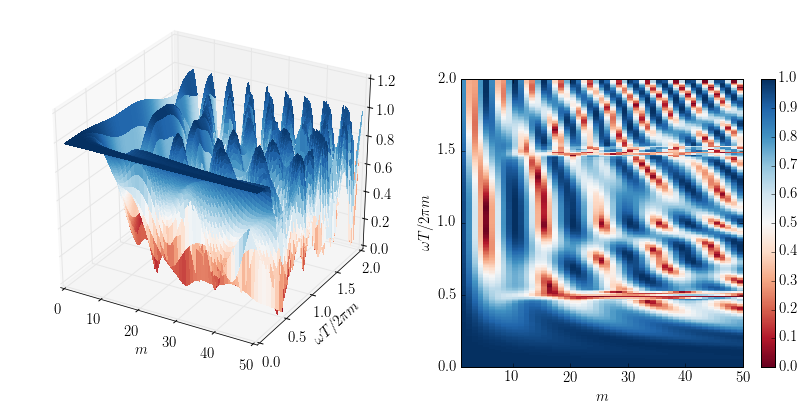

In [35]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
axes = []
axes.append(fig.add_axes([0.1, 0.1, 0.4, 1], projection='3d'))
p = axes[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu,
                         linewidth=0, antialiased=False, vmin=0, vmax=1)
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\omega T/2\pi m$')

axes.append(fig.add_axes([0.55, 0.1, 0.35, 0.8]))
p = axes[1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=1)
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_xlabel(r'$m$')
axes[1].set_ylabel(r'$\omega T/2\pi m$')
axes[1].set_xlim([1, 50]);

#### Changing the order of approximated time-evolution

In [87]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into two parts:
H_list = [wc * a.dag() * a + g * (a.dag() * sm.dag() + a * sm),
          0.5 * wa * sz + g * (a * sm.dag() + a.dag() * sm)]
H = sum(H_list)

In [88]:
H_list.reverse()

In [89]:
X, Y = np.meshgrid(m_list, T_list)
Z = np.zeros((len(T_list), len(m_list)))

for i1, m in enumerate(m_list):
    for i2, T in enumerate(T_list):
        rho_af = U_a(H_list, T, m) * psi0
        rho_0f = U(H, T) * psi0
        Z[i2, i1] = fidelity(rho_af, rho_0f)

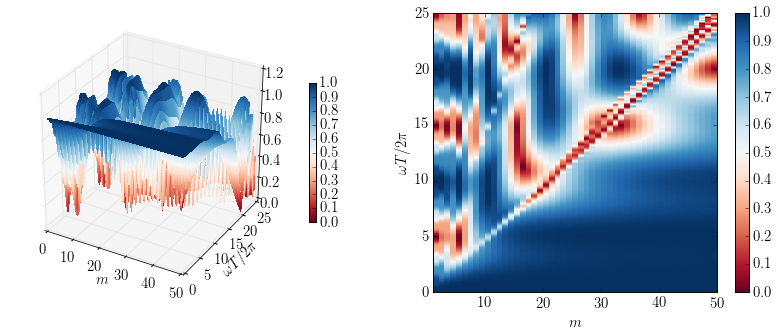

In [90]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
axes = []
axes.append(fig.add_subplot(1, 2, 1, projection='3d'))
p = axes[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu,
                         linewidth=0, antialiased=False, vmin=0, vmax=1)
cb = fig.colorbar(p, shrink=0.5)
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\omega T /2\pi$')

axes.append(fig.add_subplot(1, 2, 2))
p = axes[1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=1)
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_xlabel(r'$m$')
axes[1].set_xlim([1, M])
axes[1].set_ylabel(r'$\omega T /2\pi$');

In [91]:
T_m_list = np.arange(0, 2, 1e-2)

X, Y = np.meshgrid(m_list, T_m_list)
Z = np.zeros((len(T_m_list), len(m_list)))

for i1, m in enumerate(m_list):
    for i2, T_m in enumerate(T_m_list):
        T = m * T_m
        rho_af = U_a(H_list, T, m) * psi0
        rho_0f = U(H, T) * psi0
        Z[i2, i1] = fidelity(rho_af, rho_0f)

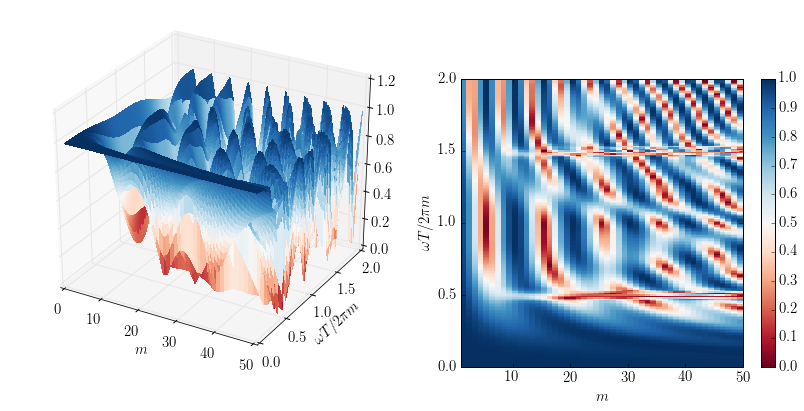

In [92]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
axes = []
axes.append(fig.add_axes([0.1, 0.1, 0.4, 1], projection='3d'))
p = axes[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu,
                         linewidth=0, antialiased=False, vmin=0, vmax=1)
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\omega T/2\pi m$')

axes.append(fig.add_axes([0.55, 0.1, 0.35, 0.8]))
p = axes[1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=1)
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_xlabel(r'$m$')
axes[1].set_ylabel(r'$\omega T/2\pi m$')
axes[1].set_xlim([1, 50]);

## Decomposition into three parts

This time, we decompose the Rabi Hamiltonian into three parts which do not (apparently) commute with each other.

$$
\hat{H} = \hat{H}_1 + \hat{H}_2 + \hat{H}_3
$$

$$\hat{H}_1 = \frac{1}{2} \hbar \Omega \hat{\sigma}_z + \hbar \omega \hat{a}^\dagger \hat{a}\quad \textrm{(non-interacting Hamiltonian)},\\  \hat{H}_2 = \hbar g (\hat{\sigma}_+ \hat{a}^\dagger + \hat{\sigma}_- \hat{a})\quad\textrm{(counter-rotating interaction Hamiltonian)},\\ \hat{H}_3 = \hbar g (\hat{\sigma}_+ \hat{a} + \hat{\sigma}_- \hat{a}^\dagger) \quad \textrm{(co-rotating interaction Hamiltonian)}.$$

In [93]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into three parts:
H_list = [wc * a.dag() * a + wa * sm.dag() * sm,
          g * (a.dag() * sm.dag() + a * sm),
          g * (a * sm.dag() + a.dag() * sm)]
H = sum(H_list)

In [ ]:
X, Y = np.meshgrid(m_list, T_list)
Z = np.zeros((len(T_list), len(m_list)))

for i1, m in enumerate(m_list):
    for i2, T in enumerate(T_list):
        rho_af = U_a(H_list, T, m) * psi0
        rho_0f = U(H, T) * psi0
        Z[i2, i1] = fidelity(rho_af, rho_0f)

In [ ]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
axes = []
axes.append(fig.add_axes([0.1, 0.1, 0.4, 1], projection='3d'))
p = axes[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu,
                         linewidth=0, antialiased=False, vmin=0, vmax=1)
cb = fig.colorbar(p, shrink=0.5)
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\omega T /2\pi$')

axes.append(fig.add_axes([0.55, 0.1, 0.35, 0.8]))
p = axes[1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=1)
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_xlabel(r'$m$')
axes[1].set_xlim([1, M])
axes[1].set_ylabel(r'$\omega T /2\pi$');

Increasing coupling strength ($g = 0.1\omega$),

In [ ]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.1 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into three parts:
H_list = [wc * a.dag() * a + wa * sm.dag() * sm,
          g * (a.dag() * sm.dag() + a * sm),
          g * (a * sm.dag() + a.dag() * sm)]

H = sum(H_list)

In [ ]:
X, Y = np.meshgrid(m_list, T_list)
Z = np.zeros((len(T_list), len(m_list)))

for i1, m in enumerate(m_list):
    for i2, T in enumerate(T_list):
        rho_af = U_a(H_list, T, m) * psi0
        rho_0f = U(H, T) * psi0
        Z[i2, i1] = fidelity(rho_af, rho_0f)

In [ ]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
axes = []
axes.append(fig.add_axes([0.1, 0.1, 0.4, 1], projection='3d'))
p = axes[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu,
                         linewidth=0, antialiased=False, vmin=0, vmax=1)
cb = fig.colorbar(p, shrink=0.5)
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\omega T /2\pi$')

axes.append(fig.add_axes([0.55, 0.1, 0.35, 0.8]))
p = axes[1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=1)
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_xlabel(r'$m$')
axes[1].set_xlim([1, M])
axes[1].set_ylabel(r'$\omega T /2\pi$');

Increasing coupling strength ($g = 0.2\omega$),

In [ ]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.2 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into three parts:
H_list = [wc * a.dag() * a + wa * sm.dag() * sm,
          g * (a.dag() * sm.dag() + a * sm),
          g * (a * sm.dag() + a.dag() * sm)]
H = sum(H_list)

In [ ]:
X, Y = np.meshgrid(m_list, T_list)
Z = np.zeros((len(T_list), len(m_list)))

for i1, m in enumerate(m_list):
    for i2, T in enumerate(T_list):
        rho_af = U_a(H_list, T, m) * psi0
        rho_0f = U(H, T) * psi0
        Z[i2, i1] = fidelity(rho_af, rho_0f)

In [ ]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
axes = []
axes.append(fig.add_axes([0.1, 0.1, 0.4, 1], projection='3d'))
p = axes[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu,
                         linewidth=0, antialiased=False, vmin=0, vmax=1)
cb = fig.colorbar(p, shrink=0.5)
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\omega T /2\pi$')

axes.append(fig.add_axes([0.55, 0.1, 0.35, 0.8]))
p = axes[1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=1)
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_xlabel(r'$m$')
axes[1].set_xlim([1, M])
axes[1].set_ylabel(r'$\omega T /2\pi$');

In [37]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into five parts:
H_list = [wc * a.dag() * a + wa * sm.dag() * sm,
          g * a.dag() * sm.dag(),
          g * a * sm,
          g * a * sm.dag(),
          g * a.dag() * sm]
H = sum(H_list)

# Symmetric Decomposition

The generalized Trotter's formula can be symmetrized to the form of
$$
e^{\hat{A}_1 + \hat{A}_2 + \cdots + \hat{A}_p} = \lim_{m\rightarrow \infty} \left(e^{\hat{A}_1/2m}e^{\hat{A}_2/2m}\cdots e^{\hat{A}_{p-1}/2m}e^{\hat{A}_p/m}e^{\hat{A}_{p-1}/2m}\cdots e^{\hat{A}_2/2m} e^{\hat{A}_1/2m}\right)^m.
$$

### References

[1] H. F. Trotter, <a href="http://www.ams.org/jourcgi/jour-getitem?pii=S0002-9939-1959-0108732-6">Proc. Amer. Math. Soc. <b>10</b>, 545 (1959)</a>.<br>
[2] M. Suzuki, <a href="http://link.springer.com/10.1007/BF01609348">Commun. Math. Phys. <b>51</b>, 183 (1976)</a>.<br>
[3] M. A. Nielsen and I. L. Chuang, <i>Quantum computation and quantum information</i>, Cambridge university press (2010).

## Version Information

In [3]:
from qutip.ipynbtools import version_table; version_table()